# Working with Unknown Dataset Sizes

This notebook demonstrates the features built into OpenDP to handle unknown or private dataset sizes.

### Load exemplar dataset

In [46]:
import os
import sns as sns
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
with open(data_path) as data_file:
    data = data_file.read()

By looking at the private data, we see this dataset has 1000 observations (rows).
Oftentimes the number of observations is public information.
For example, a researcher might run a random poll of 1000 respondents and publicly announce the sample size.

However, there are cases where simply the number of observations itself can leak private information.
For example, if a dataset contained all the individuals with a rare disease in a community,
then knowing the size of the dataset would reveal how many people in the community had that condition.
In general, any given dataset may be some well-defined subset of a population.
The given dataset's size is equivalent to a count query on that subset,
so we should protect the dataset size just as we would protect any other query we want to provide privacy guarantees for.

OpenDP assumes the sample size is private information.
If you know the dataset size (or any other parameter) is publicly available,
then you are free to make use of such information while building your measurement.

OpenDP will not assume you truthfully or correctly know the size of the dataset.
Moreover, OpenDP cannot respond with an error message if you get the size incorrect;
doing so would permit an attack whereby an analyst could repeatedly guess different dataset sizes until the error message went away,
thereby leaking the exact dataset size.

If we know the dataset size, we can incorporate it into the analysis as below,
where we provide `size` as an argument to the release of a sum on age.
While the "sum of ages" is not a particularly useful statistic, it's plenty capable of demonstrating the concept.

In [47]:
from opendp.trans import *
from opendp.meas import make_base_geometric, make_base_laplace
from opendp.mod import enable_features, binary_search_param

enable_features("contrib")

with open(data_path) as data_file:
    data = data_file.read()

# Define parameters up-front
# Each parameter is either a guess, a DP release, or public information
var_names = ["age", "sex", "educ", "race", "income", "married"]  # public information
size = 1000 # public information
age_bounds = (0, 100) # an educated guess
constant = 38 # average age for entire US population (public information)

dp_sum = (
    # Load data into a dataframe of string columns
    make_split_dataframe(separator=",", col_names=var_names) >>
    # Selects a column of df, Vec<str>
    make_select_column(key="age", TOA=str) >>
    # Cast the column as Vec<Int>
    make_cast(TIA=str, TOA=int) >>
    # Impute missing values to 0
    make_impute_constant(constant) >>
    # Clamp age values
    make_clamp(bounds=age_bounds) >>
    # Resize with the known `size`
    make_bounded_resize(size=size, bounds=age_bounds, constant=constant) >>
    # Aggregate
    make_sized_bounded_sum(size=size, bounds=age_bounds) >>
    # Noise
    make_base_geometric(scale=1.)
)

release = dp_sum(data)
print("DP sum:", release)


DP sum: 44796


### Providing incorrect dataset size values

However, if we provide an incorrect value of `n` we still receive an answer.

`make_sum_measurement` is just a convenience constructor for building a sum measurement from a `size` argument.

In [48]:
preprocessor = (
    make_split_dataframe(separator=",", col_names=var_names) >>
    make_select_column(key="age", TOA=str) >>
    make_cast_default(TIA=str, TOA=int) >>
    make_clamp(age_bounds)
)

def make_sum_measurement(size):
    return make_bounded_resize(size=size, bounds=age_bounds, constant=constant) >> \
           make_sized_bounded_sum(size=size, bounds=age_bounds) >> \
           make_base_geometric(scale=1.0)

lower_n = (preprocessor >> make_sum_measurement(size=200))(data)
real_n = (preprocessor >> make_sum_measurement(size=1000))(data)
higher_n = (preprocessor >> make_sum_measurement(size=2000))(data)

print("DP sum (n=200):  {0}".format(lower_n))
print("DP sum (n=1000): {0}".format(real_n))
print("DP sum (n=2000): {0}".format(higher_n))



DP sum (n=200):  8810
DP sum (n=1000): 44797
DP sum (n=2000): 82798


### Analysis with no provided dataset size
If we do not believe we have an accurate estimate for `size` we can instead pay some of our privacy budget
to estimate the dataset size.
Then we can use that estimate in the rest of the analysis.
Here is an example:

In [49]:
# First, make the measurement
dp_count = (
    make_split_dataframe(separator=",", col_names=var_names) >>
    make_select_column(key="age", TOA=str) >>
    make_count(TIA=str) >>
    make_base_geometric(scale=1.)
)
dp_count_release = dp_count(data)
print("DP count: {0}".format(dp_count_release))

dp_sum = preprocessor >> make_sum_measurement(dp_count_release)
dp_sum_release = dp_sum(data)
print("DP sum: {0}".format(dp_sum_release))

DP count: 1001
DP sum: 44833


In [60]:
def make_count_chain(epsilon):
    count_chain = (
        make_split_dataframe(separator=",", col_names=var_names) >>
        make_select_column(key="age", TOA=str) >>
        make_count(TIA=str)
    )
    discovered_scale = binary_search_param(
        lambda s: count_chain >> make_base_geometric(scale=s),
        d_in=1,
        d_out=epsilon)

    return count_chain >> make_base_geometric(scale=discovered_scale)

def make_mean_chain(data_size, epsilon):
    mean_chain = (
        # Convert data into a dataframe of string columns
        make_split_dataframe(separator=",", col_names=var_names) >>
        # Selects a column of df, Vec<str>
        make_select_column(key="age", TOA=str) >>
        # Cast the column as Vec<float>, and fill nulls with the default value, 0.
        make_cast_default(TIA=str, TOA=float) >>
        # Clamp age values
        make_clamp(bounds=(0., 120.)) >>
        # Resize the dataset to length `count_release`.
        #     If there are fewer than `count_release` rows in the data, fill with a constant of 20.
        #     If there are more than `count_release` rows in the data, only keep `count_release` rows
        make_bounded_resize(size=data_size, bounds=(0., 120.), constant=60.) >>
        # Compute the mean
        make_sized_bounded_mean(size=data_size, bounds=(0., 120.))
    )
    discovered_scale = binary_search_param(
        lambda s: mean_chain >> make_base_laplace(scale=s),
        d_in=1,
        d_out=epsilon)

    return mean_chain >> make_base_laplace(scale=discovered_scale)

def make_sum_chain(epsilon):
    bounded_age_sum = (
        # Convert data into a dataframe where columns are of type Vec<str>
        make_split_dataframe(separator=",", col_names=var_names) >>
        # Selects a column of df, Vec<str>
        make_select_column(key="age", TOA=str) >>
        # Cast the column as Vec<float>, and fill nulls with the default value, 0.
        make_cast_default(TIA=str, TOA=float) >>
        # make_impute_constant(20.) >>
        # Clamp income values
        make_clamp(bounds=(0., 120.)) >>
        # These bounds must be identical to the clamp bounds, otherwise chaining will fail
        make_bounded_sum(bounds=(0., 120.))
    )
    discovered_scale = binary_search_param(
        lambda s: bounded_age_sum >> make_base_laplace(scale=s),
        d_in=1,
        d_out=epsilon)

    return bounded_age_sum >> make_base_laplace(scale=discovered_scale)

In [63]:
# Let's run multiple simulations
import numpy as np

enable_features("floating-point")

with open(data_path) as data_file:
    data = data_file.read()

n_sims = 1000
history = np.zeros(shape=(n_sims, 2), dtype=float)

for i in range(n_sims):
    count_chain = make_count_chain(1.)
    dp_data_size = count_chain(data)
    mean_chain = make_mean_chain(dp_data_size, 1.)
    age_mean = mean_chain(data)
    history[i,0] = dp_data_size
    history[i,1] = age_mean

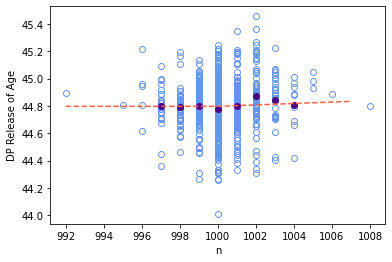

In [64]:
import statistics

import matplotlib.pyplot as plt

## plot the simulated values,
## as well as their numerical average (for any dataset size > 6 simulations),
## and finally the expected value.

# plot raw simulations
plt.plot(history[:, 0],history[:, 1], 'o', fillstyle='none', color = 'cornflowerblue')

min_count = int(min(history[:, 0]))
max_count = int(max(history[:, 0]))

count_range = range(int(min(history[:, 0])), int(max(history[:, 0])))
expected_values = np.zeros(shape=(len(count_range), 2), dtype=float)
expected_values[:, 0] = list(count_range)

data = np.genfromtxt(data_path, delimiter=',', names=var_names)
age = list(data[:]['age'])
true_mean_age = statistics.mean(age)

counter = 0
for count in count_range:
    flag = history[:,0] == count
    subhistory = history[flag,1]
    if len(subhistory)>6:
        mean_sim = np.mean(subhistory)
        # plot average simulation by dp release of dataset size
        plt.plot(count, mean_sim, 'o', color = 'indigo')
    if count<=1000:
        expected_values[counter, 1] = true_mean_age
    else:
        expected_values[counter, 1] = ((true_mean_age* 1000) + ((count-1000)*50))/count
    counter += 1

# plot the expected value by dp release of dataset size
plt.plot(expected_values[:, 0], expected_values[:, 1], linestyle='--', color = 'tomato')
plt.ylabel('DP Release of Age')
plt.xlabel('n')
plt.show()

Note that our privacy usage has increased because we apportioned some epsilon for both the release count of the dataset,
and the mean of the dataset.

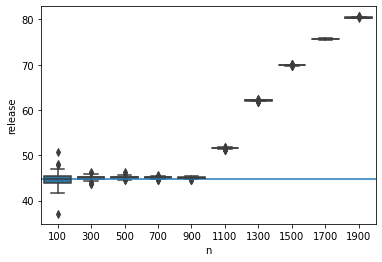

In [53]:
import pandas as pd
import seaborn as sns

enable_features("floating-point")

# initialize data
n_range = range(100, 2001, 200)
n_sims = 50
ns = []
releases = []

with open(data_path) as data_file:
    data = data_file.read()

chain = make_mean_chain(1000, 1.)
dp_mean = chain(data)
for n in n_range:
    for index in range(n_sims):
        # get mean of age
        ns.append(n)
        chain = make_mean_chain(n, 1.)
        dp_mean = chain(data)
        releases.append(dp_mean)

# get released values
values = [release for release in releases]
df = pd.DataFrame({'n': ns, 'release': values})

# get true mean
data = np.genfromtxt(data_path, delimiter=',', names=var_names)
age = list(data[:]['age'])
true_mean_age = statistics.mean(age)

# plot distribution of releases by n
plot = sns.boxplot(x = 'n', y = 'release', data = df)
plot.axhline(true_mean_age)
plt.show()

### OpenDP `resize` vs. other approaches
The standard formula for the mean of a variable is:
$\bar{x} = \frac{\sum{x}}{n}$

The conventional, and simpler, approach in the differential privacy literature, is to: 

1. compute a DP sum of the variable for the numerator
2. compute a DP count of the dataset rows for the denominator
3. take their ratio

This is sometimes called a 'plug-in' approach, as we are plugging-in differentially private answers for each of the
terms in the original formula, without any additional modifications, and using the resulting answer as our
estimate while ignoring the noise processes of differential privacy. While this 'plug-in' approach does result in a
differentially private value, the utility here is generally lower than the solution in OpenDP.  Because the number of
terms summed in the numerator does not agree with the value in the denominator, the variance is increased and the
resulting distribution becomes both biased and asymmetrical, which is visually noticeable in smaller samples.

In [54]:
with open(data_path) as data_file:
    data = data_file.read()

n_sims = 1000
history = np.zeros(shape=(n_sims, 2), dtype=float)


count_chain = make_count_chain(0.5)
sum_chain = make_sum_chain(0.5)
dp_mean = chain(data)
for index in range(n_sims):
    sum_chain = make_sum_chain(0.5)
    count_chain = make_count_chain(0.5)
    dp_sum = sum_chain(data)
    dp_count = count_chain(data)

    mean_chain = make_mean_chain(dp_count, 1.)
    dp_mean = mean_chain(data)

    history[index, 0] = dp_sum / dp_count
    history[index, 1] = dp_mean

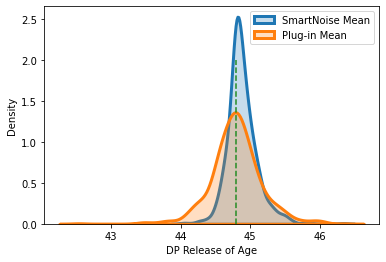

In [55]:
import seaborn as sns

data = np.genfromtxt(data_path, delimiter=',', names=var_names)
age = list(data[:]['age'])
true_mean_age = statistics.mean(age)

fig, ax = plt.subplots()
sns.kdeplot(history[:, 1], fill=True, linewidth=3,
                 label = 'SmartNoise Mean')
sns.kdeplot(history[:, 0], fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
plt.xlabel('DP Release of Age')
#plt.ylabel('Density')
leg = ax.legend()

We have noticed that for the same privacy loss,
the distribution of answers from OpenDP's resizing approach to the mean is tighter around the true dataset value (thus lower in error) than the conventional plug-in approach.

*Note, in these simulations, we've shown equal division of the epsilon for all constituent releases,
but higher utility (lower error) can be generally gained by moving more of the epsilon into the sum,
and using less in the count of the dataset rows, as in earlier examples.*